# Quantum Phase Estimation on a Grover Operator

This notebook demonstrates the capability of Classiq's QPE function, focusing on a case where it is applied on a Grover Operator. This is the core of the Amplitude Estimation algorithm.

The demonstration done for a toy model, where the Grover operator is constructed for a "good state" on 5 qubits $|\psi\rangle_{\rm good}\propto (|2\rangle+|3\rangle+|5\rangle+|7\rangle+|11\rangle+|13\rangle$).

## 1. Building a model with Classiq

In [1]:
from classiq import (
    CArray,
    CInt,
    H,
    Output,
    QArray,
    QBit,
    QNum,
    U,
    X,
    Z,
    allocate,
    allocate_num,
    control,
    create_model,
    hadamard_transform,
    invert,
    qfunc,
    qpe,
    repeat,
    synthesize,
    within_apply,
)

In [2]:
import numpy as np

NUM_QUBITS = 5
ints_to_flip = [2, 3, 5, 7, 11, 13]
precisions = [l for l in range(1, 6)]
print("precisions:", precisions)

precisions: [1, 2, 3, 4, 5]


In [3]:
transpilation_options = {"classiq": "custom", "qiskit": 3}

### 1.1 Constructing the Relevant Quantum Functions

In [4]:
# qfunc for specific state preparation


@qfunc
def my_state_preparation(states: CArray[CInt], x: QNum, ind: QBit):

    hadamard_transform(x)
    repeat(states.len, lambda i: control(x == states[i], lambda: X(ind)))

In [5]:
# qfunc for grover
import numpy as np


@qfunc
def my_grover(x: QNum, ind: QBit):
    Z(ind)  # oracle for the good state
    within_apply(
        lambda: invert(lambda: my_state_preparation(ints_to_flip, x, ind)),
        lambda: within_apply(
            lambda: (X(ind), H(ind)), lambda: control(x == 0, lambda: X(ind))
        ),  # zero oracle 1-|0><0|
    )
    U(0, 0, 0, np.pi, ind)

In [6]:
from classiq import CustomHardwareSettings, Preferences

preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

### 1.2 Synthesizing with two Different Optimization Scenarios 

In [7]:
from classiq import (
    Constraints,
    OptimizationParameter,
    QuantumProgram,
    set_constraints,
    set_preferences,
    synthesize,
)

In [8]:
classiq_depths_ae_opt_width = []
classiq_cx_counts_ae_opt_width = []
classiq_widths_ae_opt_width = []

classiq_cx_counts_ae_opt_depth_max_width = []
classiq_depths_ae_opt_depth_max_width = []
classiq_widths_ae_opt_depth_max_width = []


for precision in precisions:

    @qfunc
    def main():
        ind = QBit("ind")
        allocate(1, ind)
        x = QNum("x")
        allocate_num(NUM_QUBITS - 1, False, 0, x)
        phase = QNum("phase")
        allocate_num(precision, False, precision, phase)
        qpe(lambda: my_grover(x, ind), phase)

    qmod = create_model(main)
    qprog = synthesize(qmod)

    # width optimization
    constraints = Constraints(
        optimization_parameter=OptimizationParameter.WIDTH,
    )
    qmod = set_constraints(qmod, constraints=constraints)
    qmod = set_preferences(qmod, preferences=preferences)
    quantum_program = synthesize(qmod)
    circuit = QuantumProgram.from_qprog(quantum_program)
    classiq_widths_ae_opt_width.append(circuit.data.width)
    classiq_depths_ae_opt_width.append(circuit.transpiled_circuit.depth)
    classiq_cx_counts_ae_opt_width.append(circuit.transpiled_circuit.count_ops["cx"])

    # Depth Optimization with a Constrained Width
    constraints = Constraints(
        optimization_parameter=OptimizationParameter.DEPTH,
        max_width=15 + 3 * (precision - 1),  # setting some bound
    )
    qmod = set_constraints(qmod, constraints=constraints)
    qmod = set_preferences(qmod, preferences=preferences)
    quantum_program = synthesize(qmod)
    circuit = QuantumProgram.from_qprog(quantum_program)
    classiq_widths_ae_opt_depth_max_width.append(circuit.data.width)
    classiq_depths_ae_opt_depth_max_width.append(circuit.transpiled_circuit.depth)
    classiq_cx_counts_ae_opt_depth_max_width.append(
        circuit.transpiled_circuit.count_ops["cx"]
    )

print("classiq depths:", classiq_depths_ae_opt_width)
print("classiq cx_counts:", classiq_cx_counts_ae_opt_width)
print("classiq widths:", classiq_widths_ae_opt_width)

print("classiq depths:", classiq_depths_ae_opt_depth_max_width)
print("classiq cx_counts:", classiq_cx_counts_ae_opt_depth_max_width)
print("classiq widths:", classiq_widths_ae_opt_depth_max_width)

classiq depths: [866, 2596, 6056, 12976, 26816]
classiq cx_counts: [513, 1544, 3600, 7713, 15929]
classiq widths: [6, 7, 8, 9, 10]
classiq depths: [426, 1248, 2947, 6257, 12956]
classiq cx_counts: [241, 710, 1674, 3557, 7360]
classiq widths: [15, 18, 21, 24, 27]


## 2. Comparing to Qiskit Implementation

The qiskit data was generated using qiskit version 1.0.0. To run the qiskit code uncomment the commented cells below.

In [9]:
qiskit_depths_ae = [3094, 9262, 21596, 46254, 95560]
qiskit_cx_counts_ae = [1712, 5130, 11958, 25604, 52884]
qiskit_widths_ae = [6, 7, 8, 9, 10]

In [10]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

In [11]:
# import numpy as np
# from qiskit import QuantumCircuit, QuantumRegister, transpile
# from qiskit.circuit.library import GroverOperator, PhaseEstimation, XGate

# # building the state preparation circuit, the last qubit is the indicator of good/bad state
# state_preparation = QuantumCircuit(NUM_QUBITS)
# for q in range(NUM_QUBITS - 1):
#     state_preparation.h(q)

# for states in states_to_flip:
#     mcx = XGate().control(num_ctrl_qubits=NUM_QUBITS - 1, ctrl_state=states)
#     state_preparation.append(mcx, [k for k in range(NUM_QUBITS)])

# circuit = QuantumCircuit(NUM_QUBITS)
# circuit.compose(state_preparation, [k for k in range(NUM_QUBITS)], inplace=True)

# # building oracle
# oracle = QuantumCircuit(NUM_QUBITS)
# oracle.z(4)  # good state = last qubit is |1>

# # building the grover operator
# grover_op = GroverOperator(oracle, state_preparation=circuit, insert_barriers=True)


# qiskit_depths_ae = []
# qiskit_cx_counts_ae = []
# qiskit_widths_ae = []
# for precision in precisions:
#     qpe_qc = PhaseEstimation(precision, circuit)
#     transpiled_cir = transpile(
#         qpe_qc,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     qiskit_depths_ae.append(transpiled_cir.depth())
#     qiskit_cx_counts_ae.append(transpiled_cir.count_ops()["cx"])
#     qiskit_widths_ae.append(transpiled_cir.width())

## 3. Plotting the Data

Text(4.8, 500.0, '(b)')

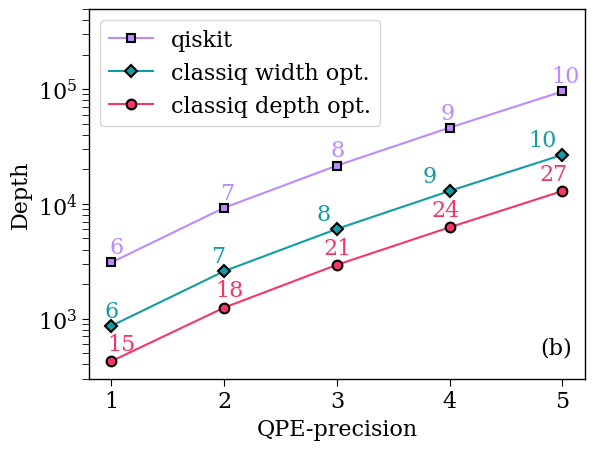

In [12]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

(qiskit1,) = plt.semilogy(
    precisions,
    qiskit_depths_ae,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    precisions,
    classiq_depths_ae_opt_width,
    "-D",
    label="classiq width opt.",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    precisions,
    classiq_depths_ae_opt_depth_max_width,
    "-o",
    label="classiq depth opt.",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)


first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="upper left"
)


plt.ylabel("Depth", fontsize=16)
plt.xlabel("QPE-precision", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=3e2, ymax=5e5)
plt.xticks(precisions)


for x, y, num_qubits in zip(
    precisions, classiq_depths_ae_opt_width, classiq_widths_ae_opt_width
):
    plt.text(x * 0.94, y * 1.2, str(num_qubits), fontsize=16, color=classiq_color)
for x, y, num_qubits in zip(
    precisions,
    classiq_depths_ae_opt_depth_max_width,
    classiq_widths_ae_opt_depth_max_width,
):
    plt.text(x * 0.96, y * 1.25, str(num_qubits), fontsize=16, color=classiq_color_1)
for x, y, num_qubits in zip(precisions, qiskit_depths_ae, qiskit_widths_ae):
    plt.text(x * 0.98, y * 1.2, str(num_qubits), fontsize=16, color=qiskit_color)
plt.text(4.8, 5e2, "(b)", fontsize=16)